In [108]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [109]:
# Define the path to your CSV files (use raw string to avoid issues with backslashes)
path = r'C:\Users\xelor\Downloads\MGMT Project\scrapped_data\*.csv'

# Read all CSV files into a list of dataframes
csv_files = glob.glob(path)
df_list = [pd.read_csv(file) for file in csv_files]

# Concatenate all dataframes into a single dataframe
data = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the merged dataframe
data

,Job Title,Company Name,Location,Skills,Years of Experience,Education,Job Type,Salary
0,Data Scientist,DTN,Remote,"Machine Learning, Pandas, Analytics, Software ...",2,Not Specified,Full-time,94;500 - 115;500 a year
1,Data Scientist,Generac Power Systems,Pewaukee; WI 53188,"Power BI, Data Visualization, Computer Science...",3,Master; Bachelor,Full-time,Not specified
2,Data Scientist,Big Lots,Columbus; OH 43081 (Albany Commons area),"Data Mining, Computer Science, Data Structures...",Not specified,Master; Bachelor,Full-time,Not specified
3,Data Scientist (Data Scientist 1),HII,Remote in Alexandria; VA,"Data Mining, Machine Learning, Project Managem...",4,Bachelor,Full-time,Not specified
4,Data Scientist,Microsoft,Atlanta; GA,"Data Mining, Forecasting, Computer Science, AP...",2,Doctorate; Master; Bachelor,Full-time,98;300 - 193;200 a year
...,...,...,...,...,...,...,...,...
729,Senior Underwriting Data Analyst,Church Mutual Insurance; S.I.,Hybrid work in Merrill; WI 54452,"Excel, SAS, Tableau, Research, Leadership",Not specified,Bachelor,Full-time,103;500 a year
730,Data Scientist,Orion,Hybrid work in West Sacramento; CA,"AI, Deep Learning, Data Visualization, Data An...",Not specified,Doctorate; Master,Not specified,Not specified
731,Deep Learning Architect; Generative AI Innovat...,Amazon Web Services; Inc.,Santa Clara; CA 94085,"AI, Sales, Deep Learning, R, AWS, Java, Cloud ...",Not specified,Bachelor; Doctorate; Master,Full-time,105;100 a year
732,Health Data Researcher; Data & Insights,WALGREENS,Deerfield; IL 60015,NaN,Not specified,Not Specified,Not specified,Not specified


In [110]:
data.head()

,Job Title,Company Name,Location,Skills,Years of Experience,Education,Job Type,Salary
0,Data Scientist,DTN,Remote,"Machine Learning, Pandas, Analytics, Software ...",2,Not Specified,Full-time,94;500 - 115;500 a year
1,Data Scientist,Generac Power Systems,Pewaukee; WI 53188,"Power BI, Data Visualization, Computer Science...",3,Master; Bachelor,Full-time,Not specified
2,Data Scientist,Big Lots,Columbus; OH 43081 (Albany Commons area),"Data Mining, Computer Science, Data Structures...",Not specified,Master; Bachelor,Full-time,Not specified
3,Data Scientist (Data Scientist 1),HII,Remote in Alexandria; VA,"Data Mining, Machine Learning, Project Managem...",4,Bachelor,Full-time,Not specified
4,Data Scientist,Microsoft,Atlanta; GA,"Data Mining, Forecasting, Computer Science, AP...",2,Doctorate; Master; Bachelor,Full-time,98;300 - 193;200 a year


In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Job Title            734 non-null    object
 1   Company Name         734 non-null    object
 2   Location             734 non-null    object
 3   Skills               569 non-null    object
 4   Years of Experience  734 non-null    object
 5   Education            734 non-null    object
 6   Job Type             734 non-null    object
 7   Salary               734 non-null    object
dtypes: object(8)
memory usage: 46.0+ KB


In [112]:
data.isna().sum()

Job Title                0
Company Name             0
Location                 0
Skills                 165
Years of Experience      0
Education                0
Job Type                 0
Salary                   0
dtype: int64

In [113]:
not_specified_count = (data == "Not specified").sum()
not_specified_count

Job Title                0
Company Name             0
Location                 0
Skills                   0
Years of Experience    361
Education                0
Job Type               326
Salary                 451
dtype: int64

In [114]:
# Cleaning "Education"
data['Education'].unique()

array(['Not Specified', 'Master; Bachelor', 'Bachelor',
       'Doctorate; Master; Bachelor', 'Master', 'Doctorate; Master',
       'Doctorate', 'Doctorate; Bachelor', 'Bachelor; Doctorate; Master',
       'Bachelor; Master', 'Bachelor; Doctorate'], dtype=object)

## Nettoyage de la Colonne "Education"

Cette section examine les données, identifie les valeurs manquantes et remplace les "Not specified" dans la colonne "Education" par "Master". De nouvelles colonnes indiquant la présence de différents niveaux d'éducation sont créées.

In [115]:
education_counts = {
    'Bachelor': data['Education'].str.contains('Bachelor', na=False).sum(),
    'Master': data['Education'].str.contains('Master', na=False).sum(),
    'Doctorate': data['Education'].str.contains('Doctorate', na=False).sum()
}

print(education_counts)

{'Bachelor': 267, 'Master': 276, 'Doctorate': 154}


In [116]:
data['Education'].replace('Not Specified', 'Master', inplace=True)

In [117]:
# Colonnes 0 ou 1 pour chaque niveau d'éducation
data['Has_Bachelor'] = data['Education'].str.contains('Bachelor', na=False).astype(int)
data['Has_Master'] = data['Education'].str.contains('Master', na=False).astype(int)
data['Has_Doctorate'] = data['Education'].str.contains('Doctorate', na=False).astype(int)

In [118]:
data

,Job Title,Company Name,Location,Skills,Years of Experience,Education,Job Type,Salary,Has_Bachelor,Has_Master,Has_Doctorate
0,Data Scientist,DTN,Remote,"Machine Learning, Pandas, Analytics, Software ...",2,Master,Full-time,94;500 - 115;500 a year,0,1,0
1,Data Scientist,Generac Power Systems,Pewaukee; WI 53188,"Power BI, Data Visualization, Computer Science...",3,Master; Bachelor,Full-time,Not specified,1,1,0
2,Data Scientist,Big Lots,Columbus; OH 43081 (Albany Commons area),"Data Mining, Computer Science, Data Structures...",Not specified,Master; Bachelor,Full-time,Not specified,1,1,0
3,Data Scientist (Data Scientist 1),HII,Remote in Alexandria; VA,"Data Mining, Machine Learning, Project Managem...",4,Bachelor,Full-time,Not specified,1,0,0
4,Data Scientist,Microsoft,Atlanta; GA,"Data Mining, Forecasting, Computer Science, AP...",2,Doctorate; Master; Bachelor,Full-time,98;300 - 193;200 a year,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
729,Senior Underwriting Data Analyst,Church Mutual Insurance; S.I.,Hybrid work in Merrill; WI 54452,"Excel, SAS, Tableau, Research, Leadership",Not specified,Bachelor,Full-time,103;500 a year,1,0,0
730,Data Scientist,Orion,Hybrid work in West Sacramento; CA,"AI, Deep Learning, Data Visualization, Data An...",Not specified,Doctorate; Master,Not specified,Not specified,0,1,1
731,Deep Learning Architect; Generative AI Innovat...,Amazon Web Services; Inc.,Santa Clara; CA 94085,"AI, Sales, Deep Learning, R, AWS, Java, Cloud ...",Not specified,Bachelor; Doctorate; Master,Full-time,105;100 a year,1,1,1
732,Health Data Researcher; Data & Insights,WALGREENS,Deerfield; IL 60015,NaN,Not specified,Master,Not specified,Not specified,0,1,0


In [119]:
data.head()

,Job Title,Company Name,Location,Skills,Years of Experience,Education,Job Type,Salary,Has_Bachelor,Has_Master,Has_Doctorate
0,Data Scientist,DTN,Remote,"Machine Learning, Pandas, Analytics, Software ...",2,Master,Full-time,94;500 - 115;500 a year,0,1,0
1,Data Scientist,Generac Power Systems,Pewaukee; WI 53188,"Power BI, Data Visualization, Computer Science...",3,Master; Bachelor,Full-time,Not specified,1,1,0
2,Data Scientist,Big Lots,Columbus; OH 43081 (Albany Commons area),"Data Mining, Computer Science, Data Structures...",Not specified,Master; Bachelor,Full-time,Not specified,1,1,0
3,Data Scientist (Data Scientist 1),HII,Remote in Alexandria; VA,"Data Mining, Machine Learning, Project Managem...",4,Bachelor,Full-time,Not specified,1,0,0
4,Data Scientist,Microsoft,Atlanta; GA,"Data Mining, Forecasting, Computer Science, AP...",2,Doctorate; Master; Bachelor,Full-time,98;300 - 193;200 a year,1,1,1


## Visualisation des Niveaux d'Éducation Demandés

C:\Users\xelor\AppData\Local\Temp\ipykernel_7576\2078660140.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(education_counts.keys()), y=list(education_counts.values()), palette='Set2')


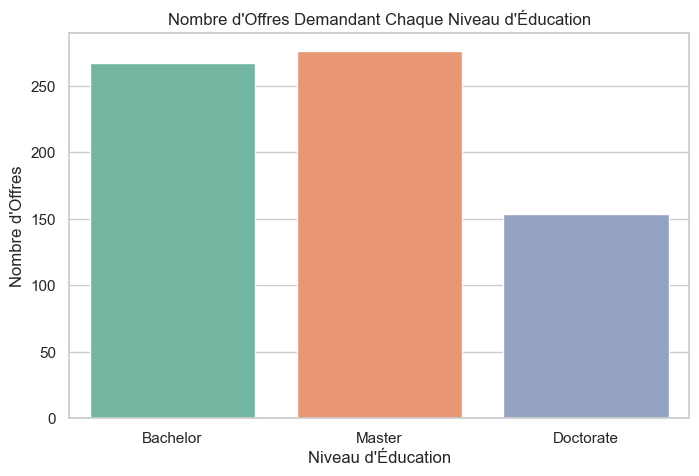

In [120]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(x=list(education_counts.keys()), y=list(education_counts.values()), palette='Set2')
plt.title('Nombre d\'Offres Demandant Chaque Niveau d\'Éducation')
plt.xlabel('Niveau d\'Éducation')
plt.ylabel('Nombre d\'Offres')
plt.show()

In [121]:
combinaisons = {
    'Just Bachelor': data[(data['Has_Bachelor'] == 1) & (data['Has_Master'] == 0) & (data['Has_Doctorate'] == 0)].shape[0],
    'Just Master': data[(data['Has_Bachelor'] == 0) & (data['Has_Master'] == 1) & (data['Has_Doctorate'] == 0)].shape[0],
    'Just Doctorate': data[(data['Has_Bachelor'] == 0) & (data['Has_Master'] == 0) & (data['Has_Doctorate'] == 1)].shape[0],
    'Bachelor and Master': data[(data['Has_Bachelor'] == 1) & (data['Has_Master'] == 1) & (data['Has_Doctorate'] == 0)].shape[0],
    'Master and Doctorate': data[(data['Has_Bachelor'] == 0) & (data['Has_Master'] == 1) & (data['Has_Doctorate'] == 1)].shape[0],
    'Bachelor and Doctorate': data[(data['Has_Bachelor'] == 1) & (data['Has_Master'] == 0) & (data['Has_Doctorate'] == 1)].shape[0],
    'All Three': data[(data['Has_Bachelor'] == 1) & (data['Has_Master'] == 1) & (data['Has_Doctorate'] == 1)].shape[0]
}

C:\Users\xelor\AppData\Local\Temp\ipykernel_7576\2423104069.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(combinaisons.keys()), y=list(combinaisons.values()), palette='Set3')


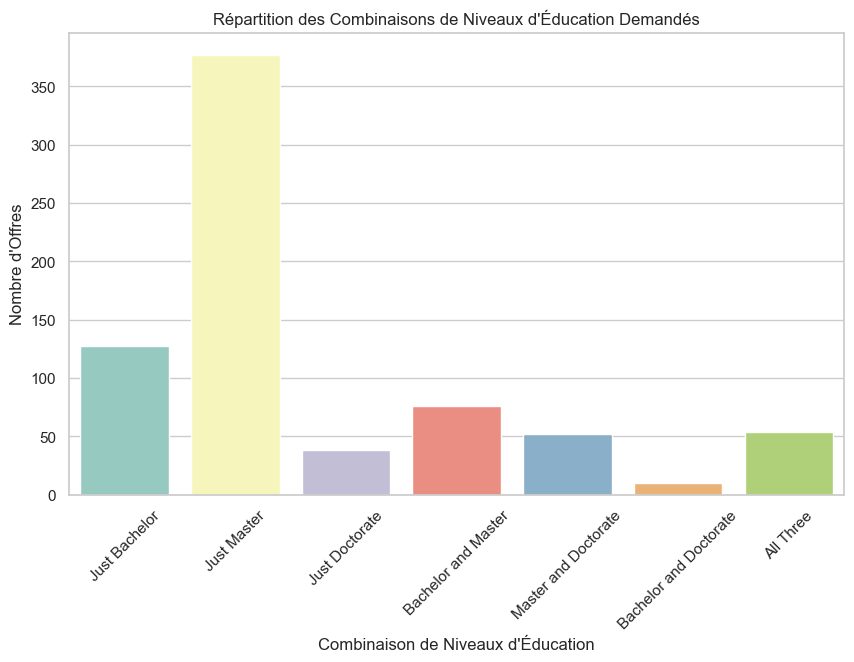

In [122]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=list(combinaisons.keys()), y=list(combinaisons.values()), palette='Set3')
plt.title('Répartition des Combinaisons de Niveaux d\'Éducation Demandés')
plt.xlabel('Combinaison de Niveaux d\'Éducation')
plt.ylabel('Nombre d\'Offres')
plt.xticks(rotation=45)
plt.show()

## Nettoyage de la Colonne "Years of Experience"

In [123]:
# Cleaning "Years of Experience"
data['Years of Experience'] = data['Years of Experience'].replace('Not specified', 0)
data['Years of Experience'] = pd.to_numeric(data['Years of Experience'])
data['Years of Experience'].unique()

array([  2,   3,   0,   4,   5,   1,   6,  13,   7,  10,   8, 240,  15,
        16,  12,  60, 100,  21,  80,  70,  30,  20, 129,   9,  18,  50,
       125,  14], dtype=int64)

In [124]:
def experience_level_name(x):
    if x <= 5:
        return 'Junior'
    elif x <= 10:
        return 'Mid-Level'
    else:
        return 'Senior'

In [125]:
data['Experience Level'] = data['Years of Experience'].apply(experience_level_name)

## Détermination du Niveau d'Éducation Idéal

In [126]:
def determine_ideal_level(row):
    if row['Has_Doctorate'] == 1:
        return 'Doctorate'
    elif row['Has_Master'] == 1:
        return 'Master'
    elif row['Has_Bachelor'] == 1:
        return 'Bachelor'
    else:
        return np.nan

In [127]:
data['Ideal_Level'] = data.apply(determine_ideal_level, axis=1)

In [128]:
data.head()

,Job Title,Company Name,Location,Skills,Years of Experience,Education,Job Type,Salary,Has_Bachelor,Has_Master,Has_Doctorate,Experience Level,Ideal_Level
0,Data Scientist,DTN,Remote,"Machine Learning, Pandas, Analytics, Software ...",2,Master,Full-time,94;500 - 115;500 a year,0,1,0,Junior,Master
1,Data Scientist,Generac Power Systems,Pewaukee; WI 53188,"Power BI, Data Visualization, Computer Science...",3,Master; Bachelor,Full-time,Not specified,1,1,0,Junior,Master
2,Data Scientist,Big Lots,Columbus; OH 43081 (Albany Commons area),"Data Mining, Computer Science, Data Structures...",0,Master; Bachelor,Full-time,Not specified,1,1,0,Junior,Master
3,Data Scientist (Data Scientist 1),HII,Remote in Alexandria; VA,"Data Mining, Machine Learning, Project Managem...",4,Bachelor,Full-time,Not specified,1,0,0,Junior,Bachelor
4,Data Scientist,Microsoft,Atlanta; GA,"Data Mining, Forecasting, Computer Science, AP...",2,Doctorate; Master; Bachelor,Full-time,98;300 - 193;200 a year,1,1,1,Junior,Doctorate


## Visualisation des Niveaux d'Expérience

In [129]:
experience_counts = data['Experience Level'].value_counts()

C:\Users\xelor\AppData\Local\Temp\ipykernel_7576\746671227.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=experience_counts.index, y=experience_counts.values, palette='pastel')


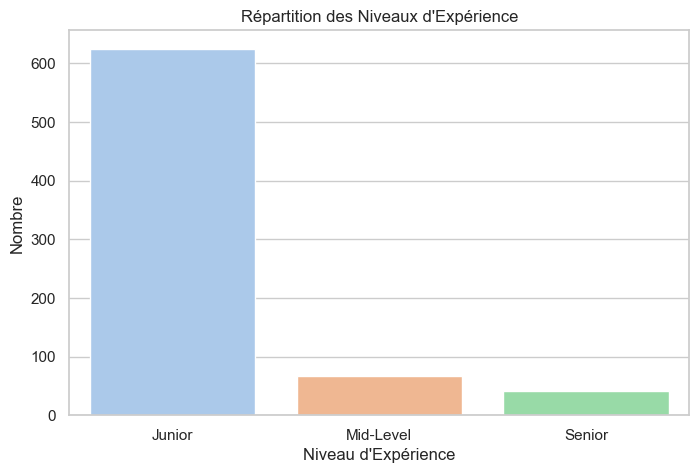

In [130]:
plt.figure(figsize=(8, 5))
sns.barplot(x=experience_counts.index, y=experience_counts.values, palette='pastel')
plt.title('Répartition des Niveaux d\'Expérience')
plt.xlabel('Niveau d\'Expérience')
plt.ylabel('Nombre')
plt.show()

## Nettoyage de la Colonne "Job Type"

In [131]:
full_time_count = (data['Job Type'] == "Full-time").sum()
full_time_count

402

In [132]:
part_time_count = (data['Job Type'] == "Part-time").sum()
part_time_count

6

In [133]:
internship_count = (data['Job Type'] == "Internship").sum()
internship_count

0

In [134]:
data['Job Type'].replace("Not specified", "Full-time", inplace = True)

In [135]:
full_time_count = (data['Job Type'] == "Full-time").sum()
full_time_count

728

## Conversion des Salaires

In [136]:
data['Salary'].unique()

array(['94;500 - 115;500 a year', 'Not specified',
       '98;300 - 193;200 a year', '80;000 - 105;000 a year',
       '92;400 - 115;500 a year', '139;395 - 181;216 a year',
       '66;220 - 108;180 a year', '82;915 - 175;100 a year',
       '125;000 - 140;000 a year', '76;128 - 124;800 a year',
       '85;000 - 106;300 a year', '75;600 - 172;000 a year',
       '98;717 - 196;000 a year', '152;000 - 190;000 a year',
       '119;700 - 222;300 a year', '108;306 - 170;000 a year',
       '94;500 - 196;000 a year', '143;850 - 221;550 a year',
       '107;766 - 153;951 a year', '97;500 - 173;675 a year',
       '85;000 - 100;000 a year', '88;000 - 173;200 a year',
       '130;000 - 170;000 a year', '168;000 - 252;000 a year',
       '112;404 a year', '138;900 - 256;500 a year',
       '103;000 - 163;000 a year', '123;000 - 185;000 a year',
       '81;000 - 162;000 a year', '130;000 - 155;000 a year',
       '123;480 - 206;040 a year', '100;000 - 130;000 a year',
       '$102;600 - $178;600 

In [137]:
def convert_salary(salary_str):
    salary_str = salary_str.replace(';', '').replace(',', '').replace('an hour', '').strip()
    
    if 'Not specified' in salary_str:
        return np.nan
    elif 'a year' in salary_str:
        salary_str = salary_str.replace('a year', '').strip()
        if '-' in salary_str:
            # Conversion une fourchette de salaire annuel
            low, high = map(float, salary_str.split('-'))
            return (low + high) / 2
        else:
            # Conversion un salaire fixe annuel
            return float(salary_str)
    elif 'an hour' in salary_str:
        # Conversion un salaire horaire en salaire annuel
        if '-' in salary_str:
            low, high = map(float, salary_str.split('-'))
            return ((low + high) / 2) * 40 * 52
        else:
            return float(salary_str) * 40 * 52

In [138]:
data['Converted Salary'] = data['Salary'].apply(lambda x: convert_salary(x) if x != 'Not specified' else np.nan)

In [139]:
median_salary = data['Converted Salary'].median()

In [182]:
data['Salary'] = data['Salary'].replace('Not specified', median_salary)
data['Converted Salary'].fillna(median_salary, inplace=True)
data['Converted Salary'].isna().sum()

0

## Visualisation de la Distribution des Salaires

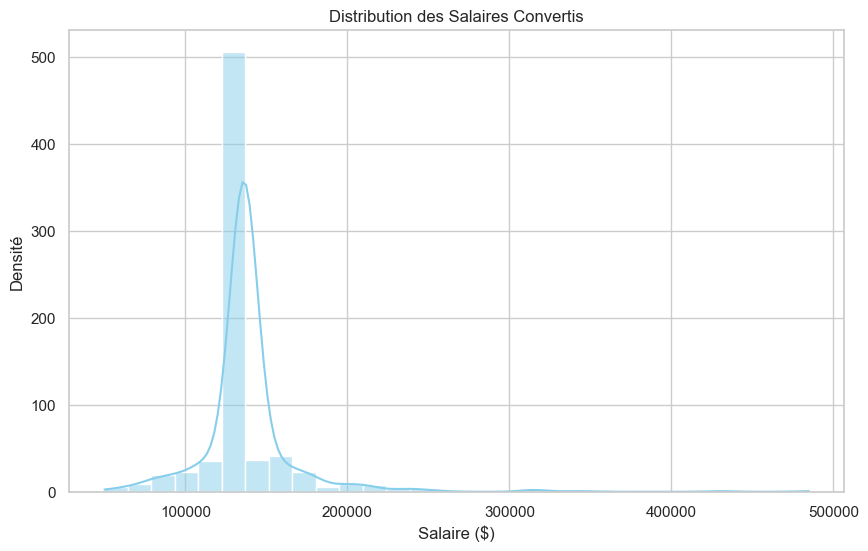

In [141]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data['Converted Salary'], bins=30, kde=True, color="skyblue")
plt.title('Distribution des Salaires Convertis')
plt.xlabel('Salaire ($)')
plt.ylabel('Densité')
plt.show()

## Traitement des Compétences

In [142]:
skills_dummies = data['Skills'].str.get_dummies(sep=',')

In [143]:
data = pd.concat([data, skills_dummies], axis=1)

In [144]:
data.head()

,Job Title,Company Name,Location,Skills,Years of Experience,Education,Job Type,Salary,Has_Bachelor,Has_Master,...,Research,Risk Management,SQL,Sales,Scripting,Software development,Spark,Tableau,TensorFlow,XML
0,Data Scientist,DTN,Remote,"Machine Learning, Pandas, Analytics, Software ...",2,Master,Full-time,94;500 - 115;500 a year,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Data Scientist,Generac Power Systems,Pewaukee; WI 53188,"Power BI, Data Visualization, Computer Science...",3,Master; Bachelor,Full-time,136000.0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,Data Scientist,Big Lots,Columbus; OH 43081 (Albany Commons area),"Data Mining, Computer Science, Data Structures...",0,Master; Bachelor,Full-time,136000.0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,Data Scientist (Data Scientist 1),HII,Remote in Alexandria; VA,"Data Mining, Machine Learning, Project Managem...",4,Bachelor,Full-time,136000.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Data Scientist,Microsoft,Atlanta; GA,"Data Mining, Forecasting, Computer Science, AP...",2,Doctorate; Master; Bachelor,Full-time,98;300 - 193;200 a year,1,1,...,0,0,0,0,0,0,0,0,0,0


In [145]:
# Assuming `data` is your DataFrame and it is already defined.
skill_frenquency = data.loc[:, ' A/B Testing':' Statistics'].sum() / len(data)
print(skill_frenquency)

 A/B Testing             0.021798
 AI                      0.080381
 APIs                    0.044959
 AWS                     0.143052
 Accounting              0.006812
                           ...   
 Software development    0.080381
 Spark                   0.057221
 Statistical Analysis    0.140327
 Statistical Software    0.047684
 Statistics              0.449591
Length: 97, dtype: float64


In [146]:
print(list(data.columns))

['Job Title', 'Company Name', 'Location', 'Skills', 'Years of Experience', 'Education', 'Job Type', 'Salary', 'Has_Bachelor', 'Has_Master', 'Has_Doctorate', 'Experience Level', 'Ideal_Level', 'Converted Salary', ' A/B Testing', ' AI', ' APIs', ' AWS', ' Accounting', ' Agile', ' Analysis Skills', ' Analytics', ' Azure', ' Banking', ' Big Data', ' Business Analysis', ' CI/CD', ' Cloud Computing', ' Computer Science', ' Computer Vision', ' Data Analysis', ' Data Analysis Skills', ' Data Analytics', ' Data Engineering', ' Data Mining', ' Data Structures', ' Data Visualization', ' Data Warehouse', ' Data lake', ' Deep Learning', ' Distributed Systems', ' Docker', ' Encryption', ' Excel', ' Feature Extraction', ' Financial Services', ' Forecasting', ' Git', ' Github', ' Go', ' Google Cloud', ' GraphQL', ' HBase', ' Hadoop', ' Hypothesis testing', ' JSON', ' Java', ' Jira', ' Julia', ' Kafka', ' Keras', ' Kubernetes', ' Leadership', ' Linux', ' MATLAB', ' MLOps', ' Machine Learning', ' Machin

In [147]:
top_skills = skill_frenquency.sort_values(ascending=False).head(10)
top_skills

 Python              0.546322
 Machine Learning    0.486376
 Statistics          0.449591
 SQL                 0.420981
 Analytics           0.415531
 Computer Science    0.382834
 Research            0.363760
 R                   0.311989
 Data Analysis       0.226158
 Leadership          0.204360
dtype: float64

## Visualisation des Compétences les Plus Demandées

C:\Users\xelor\AppData\Local\Temp\ipykernel_7576\765550516.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_skills.values, y=top_skills.index, palette='coolwarm')


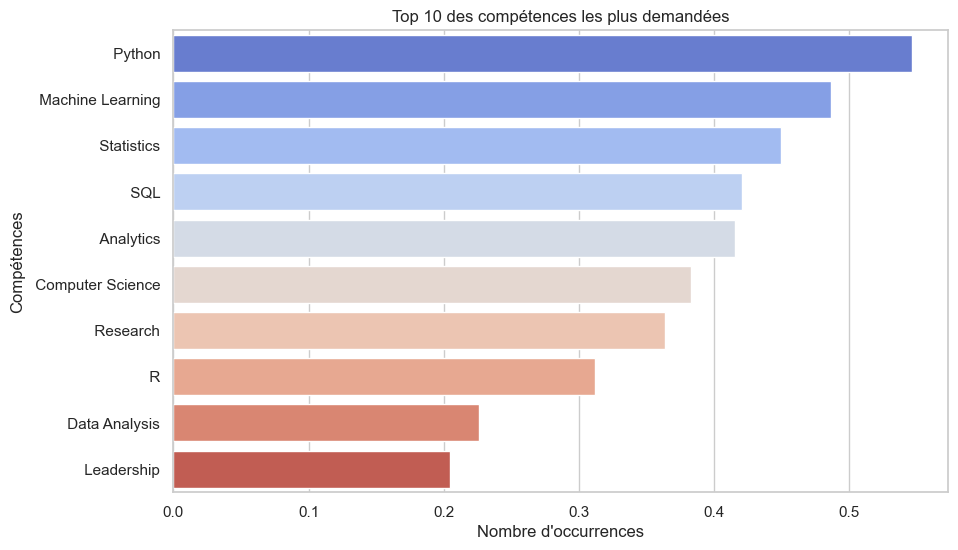

In [148]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=top_skills.values, y=top_skills.index, palette='coolwarm')
plt.title('Top 10 des compétences les plus demandées')
plt.xlabel('Nombre d\'occurrences')
plt.ylabel('Compétences')
plt.show()

## Scoring des Compétences, Niveaux d'Éducation et Expérience

In [149]:
skill_scores = skill_frenquency ** 2

In [150]:
# Ensure the skill_scores index matches the columns of skills_dummies
skill_scores = skill_scores.reindex(skills_dummies.columns, fill_value=0)

# Calculate the Skills Score
data['Skills Score'] = skills_dummies.dot(skill_scores)


In [151]:
max_score_skill = skill_scores.sum()

In [152]:
data['Skills Score'] = data['Skills Score'] / max_score_skill

In [153]:
diversity_bonus = skills_dummies.sum(axis=1) / len(skill_scores)

In [154]:
data['Skills Score'] += (diversity_bonus * 0.1) * (data['Skills Score'] > 0)

In [155]:
# Scoring pondéré niveau d'éducation

def education_score(row):
    score = 0
    if row['Has_Doctorate']:
        score += 3
    elif row['Has_Master']:
        score += 2
    elif row['Has_Bachelor']:
        score += 1
    
    # Bonus pour les cas où le niveau idéal est atteint
    if row['Ideal_Level'] == 'Doctorate' and row['Has_Doctorate']:
        score += 1 
    elif row['Ideal_Level'] == 'Master' and row['Has_Master']:
        score += 0.5

    return score

In [156]:
# Score Education
data['Education Score'] = data.apply(education_score, axis=1)

# Normalisation
data['Education Score'] = data['Education Score'] / 4

In [157]:
# Poids
def experience_level(x):
    if x <= 5:
        return 1  # Junior
    elif x <= 10:
        return 2  # Mid-Level
    else:
        return 3  # Senior

In [158]:
# Score Experience
data['Experience Score'] = data['Years of Experience'].apply(experience_level)

# Normalisation
data['Experience Score'] = data['Experience Score'] / 3

In [159]:
data.head()

,Job Title,Company Name,Location,Skills,Years of Experience,Education,Job Type,Salary,Has_Bachelor,Has_Master,...,Sales,Scripting,Software development,Spark,Tableau,TensorFlow,XML,Skills Score,Education Score,Experience Score
0,Data Scientist,DTN,Remote,"Machine Learning, Pandas, Analytics, Software ...",2,Master,Full-time,94;500 - 115;500 a year,0,1,...,0,0,0,0,0,0,0,0.343558,0.625,0.333333
1,Data Scientist,Generac Power Systems,Pewaukee; WI 53188,"Power BI, Data Visualization, Computer Science...",3,Master; Bachelor,Full-time,136000.0,1,1,...,0,0,0,0,0,0,0,0.773775,0.625,0.333333
2,Data Scientist,Big Lots,Columbus; OH 43081 (Albany Commons area),"Data Mining, Computer Science, Data Structures...",0,Master; Bachelor,Full-time,136000.0,1,1,...,0,0,0,0,0,0,0,0.621591,0.625,0.333333
3,Data Scientist (Data Scientist 1),HII,Remote in Alexandria; VA,"Data Mining, Machine Learning, Project Managem...",4,Bachelor,Full-time,136000.0,1,0,...,0,0,0,0,0,0,0,0.153763,0.250,0.333333
4,Data Scientist,Microsoft,Atlanta; GA,"Data Mining, Forecasting, Computer Science, AP...",2,Doctorate; Master; Bachelor,Full-time,98;300 - 193;200 a year,1,1,...,0,0,0,0,0,0,0,0.727107,1.000,0.333333


## Calcul du Score d'Employabilité

In [160]:
# Scoing Emploiyabilité

# Compétences (Skills Score) : 50%
# Années d'Expérience (Experience Score) : 30%
# Niveau d'Éducation (Education Score) : 20%
# Des poids donnés selon l'importance

# Poids
data['Employability Score'] = (data['Skills Score'] * 0.5 + 
                               data['Experience Score'] * 0.3 + 
                               data['Education Score'] * 0.2)

In [161]:
# Normalisation 
max_score_emp = data['Employability Score'].max()

In [162]:
data['Employability Score'] = data['Employability Score'] / max_score_emp

In [163]:
data.head()

,Job Title,Company Name,Location,Skills,Years of Experience,Education,Job Type,Salary,Has_Bachelor,Has_Master,...,Scripting,Software development,Spark,Tableau,TensorFlow,XML,Skills Score,Education Score,Experience Score,Employability Score
0,Data Scientist,DTN,Remote,"Machine Learning, Pandas, Analytics, Software ...",2,Master,Full-time,94;500 - 115;500 a year,0,1,...,0,0,0,0,0,0,0.343558,0.625,0.333333,0.445527
1,Data Scientist,Generac Power Systems,Pewaukee; WI 53188,"Power BI, Data Visualization, Computer Science...",3,Master; Bachelor,Full-time,136000.0,1,1,...,0,0,0,0,0,0,0.773775,0.625,0.333333,0.687064
2,Data Scientist,Big Lots,Columbus; OH 43081 (Albany Commons area),"Data Mining, Computer Science, Data Structures...",0,Master; Bachelor,Full-time,136000.0,1,1,...,0,0,0,0,0,0,0.621591,0.625,0.333333,0.601624
3,Data Scientist (Data Scientist 1),HII,Remote in Alexandria; VA,"Data Mining, Machine Learning, Project Managem...",4,Bachelor,Full-time,136000.0,1,0,...,0,0,0,0,0,0,0.153763,0.250,0.333333,0.254756
4,Data Scientist,Microsoft,Atlanta; GA,"Data Mining, Forecasting, Computer Science, AP...",2,Doctorate; Master; Bachelor,Full-time,98;300 - 193;200 a year,1,1,...,0,0,0,0,0,0,0.727107,1.000,0.333333,0.745078


## Visualisation des Scores

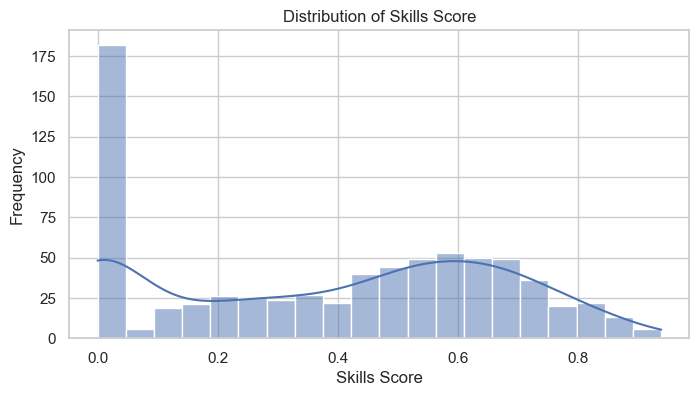

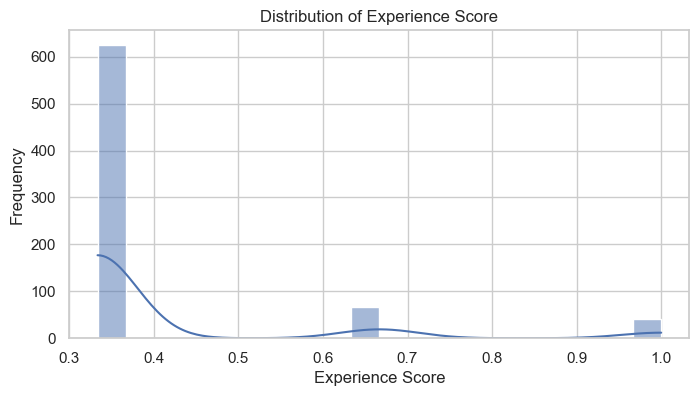

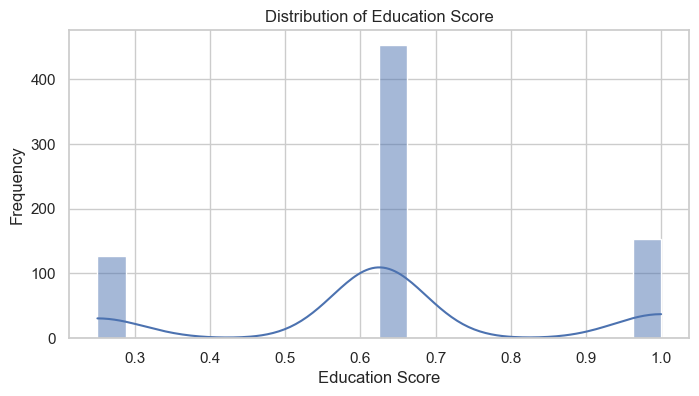

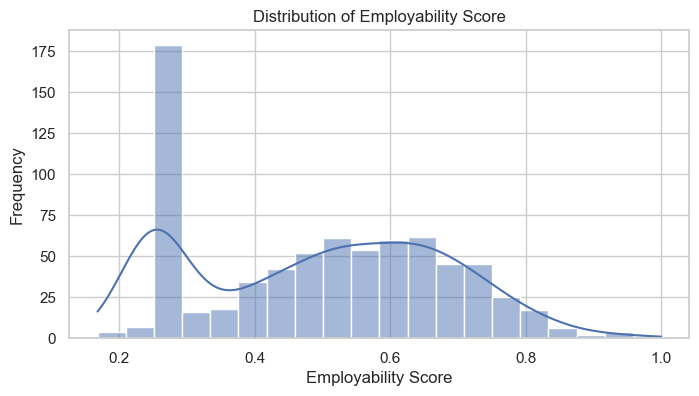

In [164]:
sns.set_theme(style="whitegrid")
for column in ['Skills Score', 'Experience Score', 'Education Score', 'Employability Score']:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[column], bins=20, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

## Création de la Variable Cible

In [165]:
employability_scores = data['Employability Score']

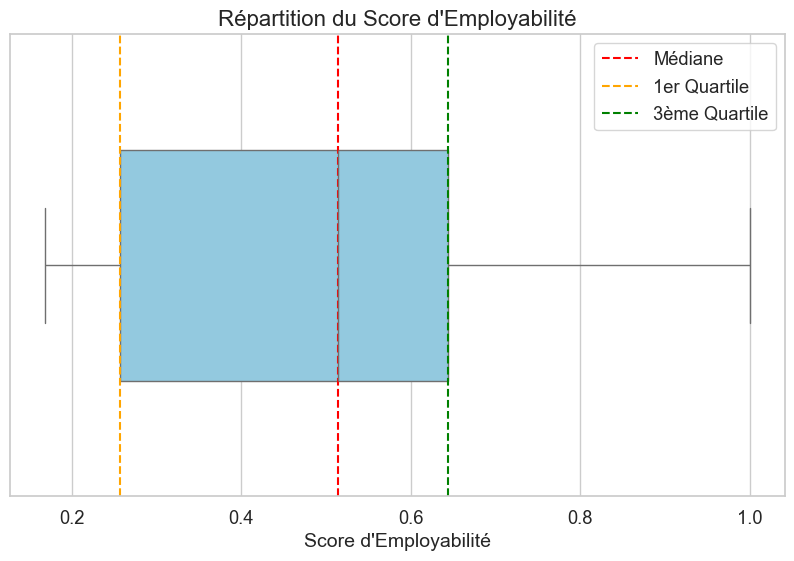

In [166]:
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)
plt.figure(figsize=(10, 6))
box = sns.boxplot(x=employability_scores, width=0.5, fliersize=5, color='skyblue')
median = employability_scores.median()
plt.axvline(x=median, color='red', linestyle='--', label='Médiane')
plt.axvline(x=employability_scores.quantile(0.25), color='orange', linestyle='--', label='1er Quartile')
plt.axvline(x=employability_scores.quantile(0.75), color='green', linestyle='--', label='3ème Quartile')
plt.title('Répartition du Score d\'Employabilité', fontsize=16)
plt.xlabel('Score d\'Employabilité', fontsize=14)
plt.ylabel('')
plt.legend()
plt.show()

In [167]:
# le premier quartile comme seuil
seuil = data['Employability Score'].quantile(0.5) # pour ne pas être très seléctif on choisit le premier quartile

# Les scores >= seuil sont employables (1)
# Les scores < seuil sont non employables (0)
data['Employability'] = (data['Employability Score'] >= seuil).astype(int)

In [168]:
data.head()

,Job Title,Company Name,Location,Skills,Years of Experience,Education,Job Type,Salary,Has_Bachelor,Has_Master,...,Software development,Spark,Tableau,TensorFlow,XML,Skills Score,Education Score,Experience Score,Employability Score,Employability
0,Data Scientist,DTN,Remote,"Machine Learning, Pandas, Analytics, Software ...",2,Master,Full-time,94;500 - 115;500 a year,0,1,...,0,0,0,0,0,0.343558,0.625,0.333333,0.445527,0
1,Data Scientist,Generac Power Systems,Pewaukee; WI 53188,"Power BI, Data Visualization, Computer Science...",3,Master; Bachelor,Full-time,136000.0,1,1,...,0,0,0,0,0,0.773775,0.625,0.333333,0.687064,1
2,Data Scientist,Big Lots,Columbus; OH 43081 (Albany Commons area),"Data Mining, Computer Science, Data Structures...",0,Master; Bachelor,Full-time,136000.0,1,1,...,0,0,0,0,0,0.621591,0.625,0.333333,0.601624,1
3,Data Scientist (Data Scientist 1),HII,Remote in Alexandria; VA,"Data Mining, Machine Learning, Project Managem...",4,Bachelor,Full-time,136000.0,1,0,...,0,0,0,0,0,0.153763,0.250,0.333333,0.254756,0
4,Data Scientist,Microsoft,Atlanta; GA,"Data Mining, Forecasting, Computer Science, AP...",2,Doctorate; Master; Bachelor,Full-time,98;300 - 193;200 a year,1,1,...,0,0,0,0,0,0.727107,1.000,0.333333,0.745078,1


In [169]:
print(data.iloc[0])

Job Title                                                 Data Scientist
Company Name                                                         DTN
Location                                                          Remote
Skills                 Machine Learning, Pandas, Analytics, Software ...
Years of Experience                                                    2
                                             ...                        
Skills Score                                                    0.343558
Education Score                                                    0.625
Experience Score                                                0.333333
Employability Score                                             0.445527
Employability                                                          0
Name: 0, Length: 168, dtype: object


## Séparation des Données en Enseignements d'Apprentissage et de Test

In [170]:
X = data.drop(['Job Title', 'Company Name', 
               'Location', 'Skills', 'Education','Job Type' ,
                'Salary', 'Experience Level', 'Ideal_Level',
                'Skills Score', 'Education Score', 'Experience Score',
                'Employability Score', 'Employability'], axis=1)

y = data['Employability']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Configuration et Entraînement des Modèles avec GridSearchCV

In [172]:
param_grid_knn = {
    'n_neighbors': np.arange(1, 21, 2),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

param_grid_dt = {
    'max_depth': np.arange(1, 21),
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'min_samples_split': [2, 5, 10]
}

In [173]:
stratified_cv = StratifiedKFold(n_splits=5)

In [174]:
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=stratified_cv)
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=stratified_cv)

In [175]:
grid_knn.fit(X_train, y_train)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'min_samples_leaf': [1, 2, 4, 6, 8],
                         'min_samples_split': [2, 5, 10]})

In [176]:
print(f"Meilleurs paramètres KNN: {grid_knn.best_params_}")
print(f"Meilleur score KNN: {grid_knn.best_score_}")
print(f"Meilleurs paramètres DT: {grid_dt.best_params_}")
print(f"Meilleur score DT: {grid_dt.best_score_}")

Meilleurs paramètres KNN: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Meilleur score KNN: 0.8484716789801535
Meilleurs paramètres DT: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
Meilleur score DT: 0.91313921483413


## Évaluation des Modèles

In [177]:
y_pred_knn = grid_knn.predict(X_test)
y_pred_dt = grid_dt.predict(X_test)

print(f"Score de précision KNN sur Test Set: {accuracy_score(y_test, y_pred_knn)}")
print(f"Score de précision DT sur Test Set: {accuracy_score(y_test, y_pred_dt)}")

Score de précision KNN sur Test Set: 0.8367346938775511
Score de précision DT sur Test Set: 0.9047619047619048


In [178]:
target_names = ['Non Employable', 'Employable']
report = classification_report(y_test, y_pred_dt, target_names=target_names)
print(report)

                precision    recall  f1-score   support

Non Employable       0.89      0.95      0.92        83
    Employable       0.93      0.84      0.89        64

      accuracy                           0.90       147
     macro avg       0.91      0.90      0.90       147
  weighted avg       0.91      0.90      0.90       147



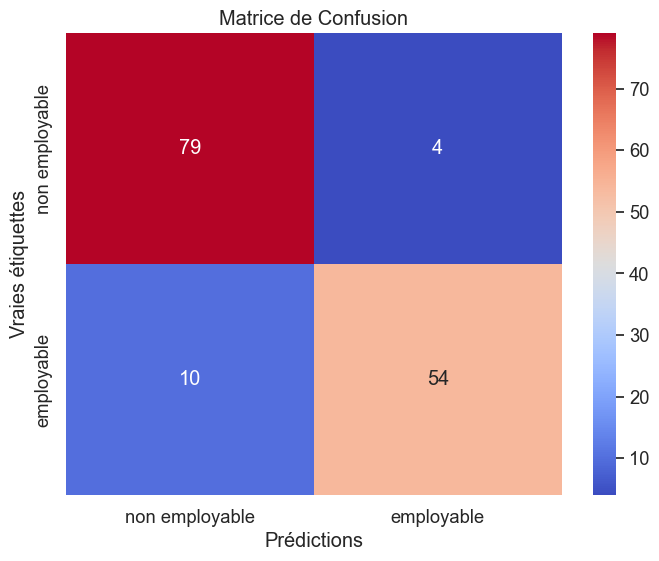

In [179]:
cm = confusion_matrix(y_test, y_pred_dt)
cm_display_labels = ['non employable', 'employable']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=cm_display_labels, yticklabels=cm_display_labels)
plt.ylabel('Vraies étiquettes')
plt.xlabel('Prédictions')
plt.title('Matrice de Confusion')
plt.show()

In [180]:
print("These are the dataframe's columns",list(data.columns))

These are the dataframe's columns ['Job Title', 'Company Name', 'Location', 'Skills', 'Years of Experience', 'Education', 'Job Type', 'Salary', 'Has_Bachelor', 'Has_Master', 'Has_Doctorate', 'Experience Level', 'Ideal_Level', 'Converted Salary', ' A/B Testing', ' AI', ' APIs', ' AWS', ' Accounting', ' Agile', ' Analysis Skills', ' Analytics', ' Azure', ' Banking', ' Big Data', ' Business Analysis', ' CI/CD', ' Cloud Computing', ' Computer Science', ' Computer Vision', ' Data Analysis', ' Data Analysis Skills', ' Data Analytics', ' Data Engineering', ' Data Mining', ' Data Structures', ' Data Visualization', ' Data Warehouse', ' Data lake', ' Deep Learning', ' Distributed Systems', ' Docker', ' Encryption', ' Excel', ' Feature Extraction', ' Financial Services', ' Forecasting', ' Git', ' Github', ' Go', ' Google Cloud', ' GraphQL', ' HBase', ' Hadoop', ' Hypothesis testing', ' JSON', ' Java', ' Jira', ' Julia', ' Kafka', ' Keras', ' Kubernetes', ' Leadership', ' Linux', ' MATLAB', ' MLO

In [181]:
# Count rows where Employability is equal to 0
employability_0_count = data[data['Employability'] == 0].shape[0]

# Count rows where Employability is equal to 1
employability_1_count = data[data['Employability'] == 1].shape[0]

print("Number of rows with Employability = 0:", employability_0_count)
print("Number of rows with Employability = 1:", employability_1_count)


Number of rows with Employability = 0: 366
Number of rows with Employability = 1: 368
